In [206]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
import random

sm.set_framework('tf.keras')
sm.framework()

from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

from keras.utils.vis_utils import plot_model

from sklearn import metrics

import math
import pandas as pd

import seaborn as sns

import ast

In [207]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [208]:
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip = True,
                      vertical_flip = True,
                      fill_mode = 'reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        target_size = (64, 64),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        target_size = (64, 64),
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [209]:
seed = 24
batch_size = 16
n_classes = 8

In [210]:
model_names = ['Unet-resnet50', 'Unet-resnet101', 'Unet-resnet152', 'Unet-densenet121', 'Unet-densenet169',
               'Unet-vgg19', 'FPN-vgg16', 'Linknet-mobilenetv2']
models_path = '/home/shrayank_mistry/Modules/current_models/model_stats/'

In [211]:
# fpn_resnext50 = load_model('/home/shrayank_mistry/Modules/current_models/model_stats/FPN_resnext50/model.hdf5', compile = False)

In [212]:
models = []
for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    print(md, bk)
    models.append(load_model(models_path + f'{md}_{bk}/model.hdf5', compile = False))

Unet resnet50
Unet resnet101
Unet resnet152
Unet densenet121
Unet densenet169
Unet vgg19
FPN vgg16
Linknet mobilenetv2


In [213]:
models

In [214]:
test_img_path = '/home/shrayank_mistry/Modules/data/kaggle_data/test_images/'
test_msk_path = '/home/shrayank_mistry/Modules/data/kaggle_data/test_masks/'

# test_img_path = '/home/shrayank_mistry/Modules/data/kaggle_data/main_test_image/'
# test_msk_path = '/home/shrayank_mistry/Modules/data/kaggle_data/main_test_mask/'

test_img_gen = trainGenerator(test_img_path, test_msk_path, num_class = n_classes)

x, y = test_img_gen.__next__()

Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.


In [215]:
# plot_model(models[0], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [216]:
image_cnt = len(os.listdir(test_img_path + 'test/'))
image_cnt

16677

In [217]:
model = models[5]

### Mean IoU for Batch Size = 16

In [255]:
test_image_batch, test_mask_batch = test_img_gen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

IOU_keras = MeanIoU(num_classes = n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax) 
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.64149314


### Pixel Accuracy for Batch Size = 16

In [256]:
pixel_acc = []
test_image_batch, test_mask_batch = test_img_gen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

for j in range(batch_size):
    correct = test_pred_batch_argmax[j] == test_mask_batch_argmax[j]
    pixel_acc.append(float(correct.sum() / (correct.shape[0] * correct.shape[1])))

In [257]:
print(f'Max Pixel Accuracy = {np.max(pixel_acc)}, Mean Pixel Accuracy = {np.mean(pixel_acc)}')

Max Pixel Accuracy = 1.0, Mean Pixel Accuracy = 0.8206024169921875


### Confusion Matrix

In [258]:
img_number = 2

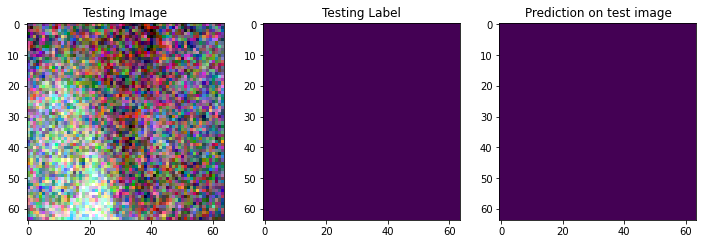

In [259]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_number])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_number])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_number])
plt.show()

In [260]:
itrs = image_cnt // batch_size
itrs

1042

In [268]:
cs = 8
confusion_matrix = np.zeros((cs, cs), dtype = 'int')

for x in range(batch_size):
    target = test_mask_batch_argmax[x]
    prediction = test_pred_batch_argmax[x]   

    r = target.shape[0]
    c = target.shape[1]

    for i in range(r):
        for j in range(c):
            target_pixel = target[i][j]
            predict_pixel = prediction[i][j]
        
            confusion_matrix[predict_pixel][target_pixel] += 1

In [266]:
confusion_matrix

array([[    0,     0,     0,     0,     0,     0,     0,     0],
       [    0,  4642,    94,   192,     0,     1,     0,     0],
       [    0,    58,  1450,   483,     0,     0,     0,     0],
       [    0,   216,   363,  8200,    51,   244,   278,     1],
       [    0,     2,     0,   196, 27435,   265,   368,  4447],
       [    0,    26,     0,   509,   185,  2091,    22,   139],
       [    0,     0,     0,   469,   366,     8,  2012,   200],
       [    0,     0,     0,     0,  2200,   157,   217,  7949]])

In [267]:
# target = test_mask_batch_argmax[img_number]
# prediction = test_pred_batch_argmax[img_number]

# cs = 8
# confusion_matrix = np.zeros((cs, cs), dtype = 'int')

# r = target.shape[0]
# c = target.shape[1]

# # print(r, c)

# for i in range(r):
#     for j in range(c):
#         target_pixel = target[i][j]
#         predict_pixel = prediction[i][j]
        
#         confusion_matrix[predict_pixel][target_pixel] += 1

# confusion_matrix

array([[   0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 4096,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])

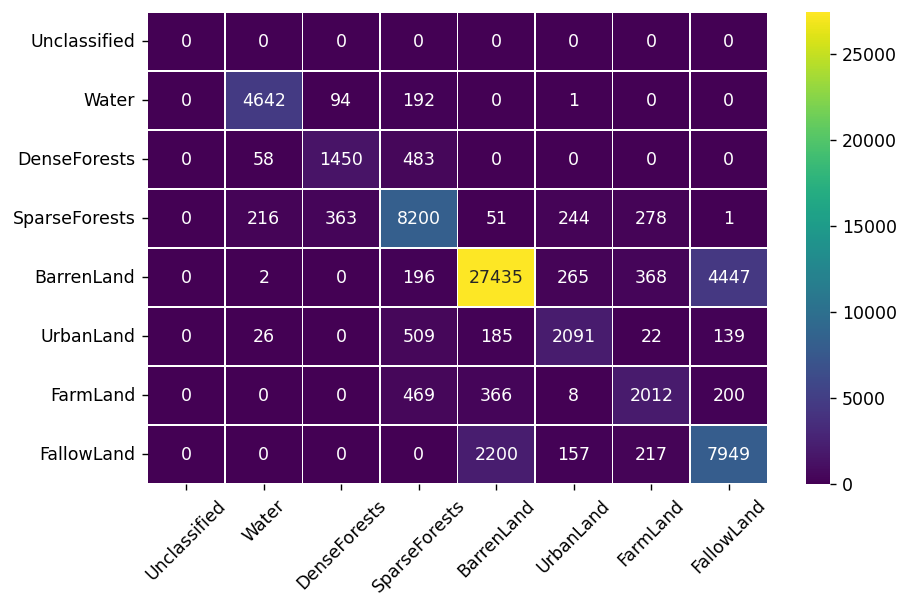

In [269]:
classes = ['Unclassified', 'Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']
headers = ['Precision', 'Recall', 'Overall-Accuracy', 'F1-Score', 'MCC']

plt.figure(figsize = (8, 5), dpi = 125)

cm_df = pd.DataFrame(data = confusion_matrix, index = classes, columns = classes)
sns.heatmap(data = cm_df, annot = True, linewidths = 0.5, 
        cmap = 'viridis', fmt = 'd');

plt.xticks(rotation = 45);

## Metrics

$$Presision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$

$$Overall Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

$$F1-Score = \frac{2 * TP}{2 * TP + FP + FN}$$

$$MCC = \frac{(TP * TN) - (FP * FN)}{\sqrt{(TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)}}$$

In [228]:
classes = ['Unclassified', 'Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']
headers = ['Precision', 'Recall', 'Overall-Accuracy', 'F1-Score', 'MCC']

# headers = ['Precision', 'Recall', 'Overall-Accuracy', 'F1-Score']

metrics = {}
for c in range(1, len(classes)):
    tp, fn, fp, tn = 0, 0, 0, 0

    p, r, o, f, m = 0, 0, 0, 0, 0

    # True Positive
    tp = confusion_matrix[c][c]
    
    # False Negative
    for i in range(len(classes)):
        if i == c: continue
        fn += confusion_matrix[c][i]
    
    # False Positive
    for i in range(len(classes)):
        if i == c: continue
        fp += confusion_matrix[i][c]
    
    # True Negative
    for i in range(len(classes)):
        if i == c: continue
        for j in range(len(classes)):
            if j == c: continue

            tn += confusion_matrix[i][j]
    
    # print(f'Class {c}, Metrics = [TP {tp}, FN {fn}, FP {fp}, TN {tn}]')

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    o = (tp + tn) / (tp + fp + tn + fn)
    f = (2 * tp) / ((2 * tp) + (fp + fn))
    m = ((tp * tn) - (fp * fn)) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

    metrics[classes[c]] = [p, r, o, f, m]
    # metrics[classes[c]] = [p, r, o, f]
    


/home/shrayank_mistry/Modules/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/home/shrayank_mistry/Modules/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


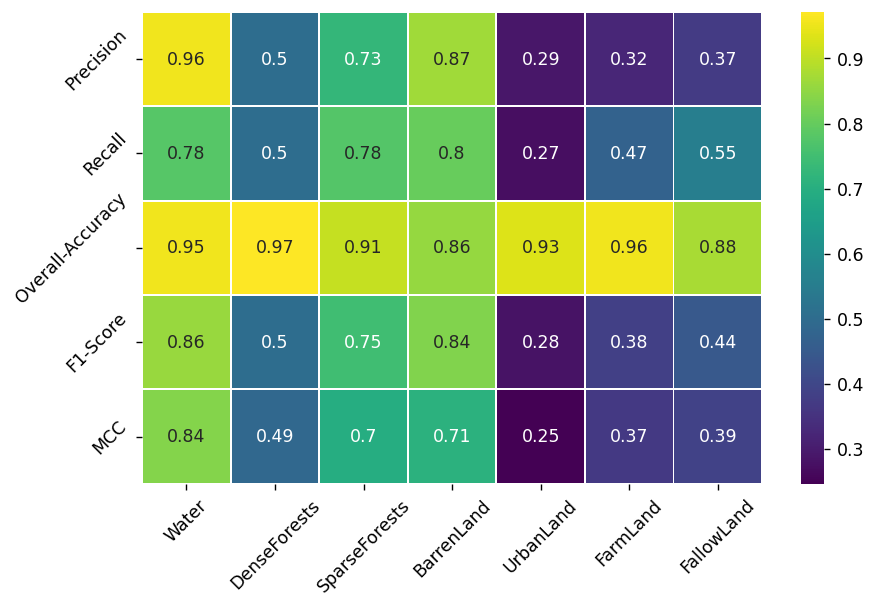

In [270]:
df = pd.DataFrame(metrics, index = headers)
plt.figure(figsize = (8, 5), dpi = 125)
sns.heatmap(data = df, annot = True, linewidths = 0.5, 
        cmap = 'viridis');

plt.yticks(rotation = 45);
plt.xticks(rotation = 45);

### Test Image Storing

/home/shrayank_mistry/Modules/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


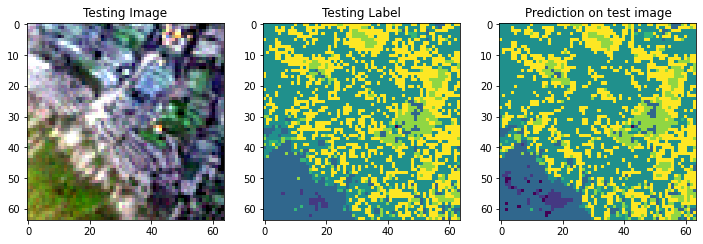

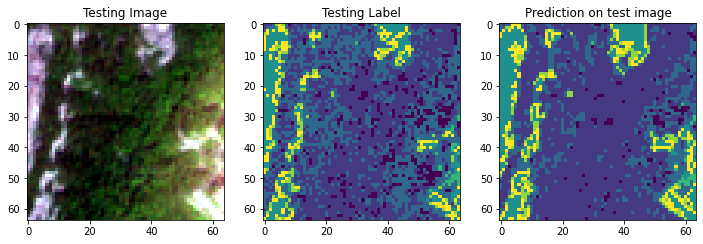

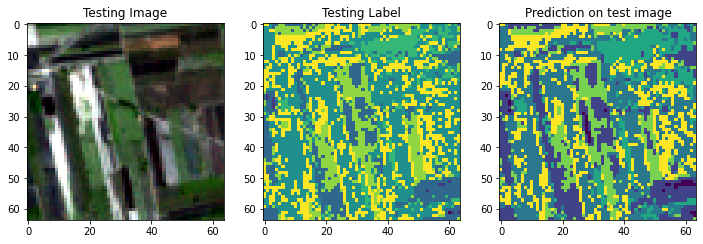

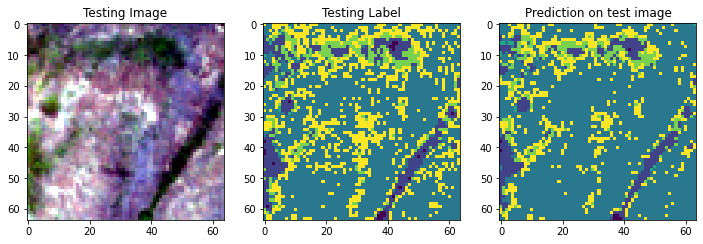

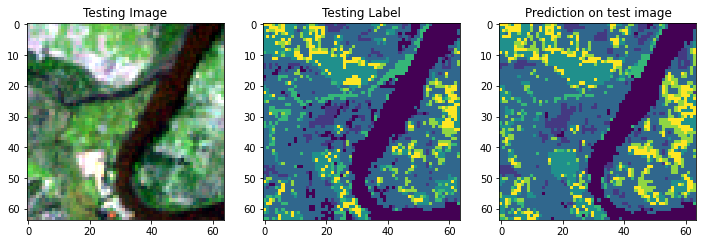

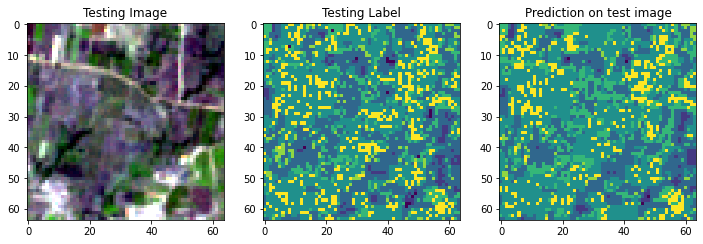

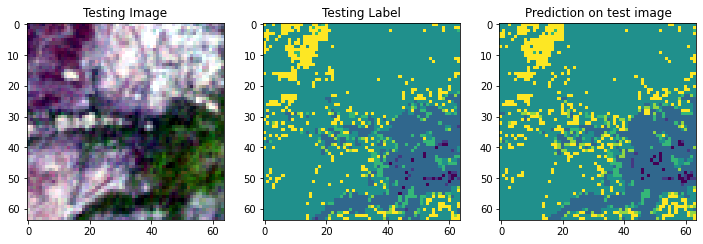

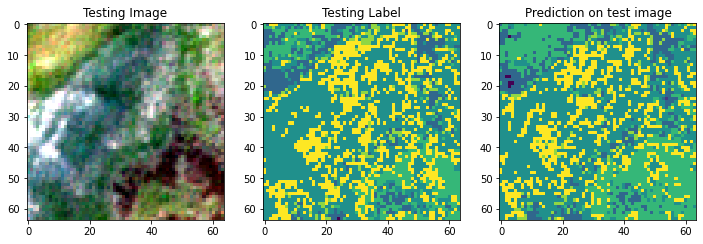

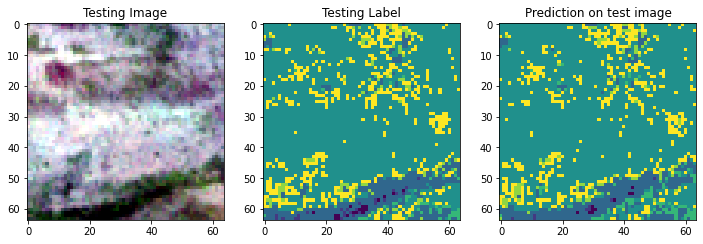

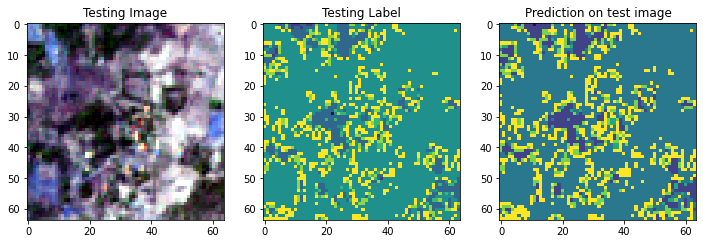

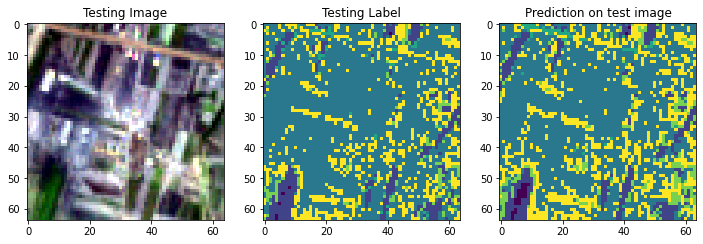

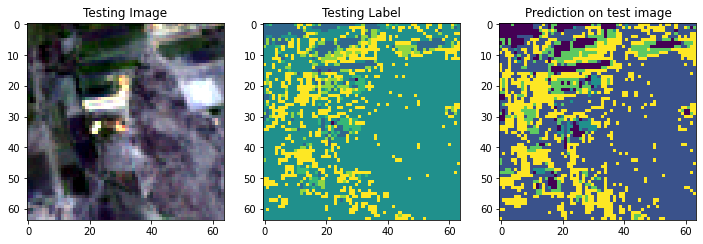

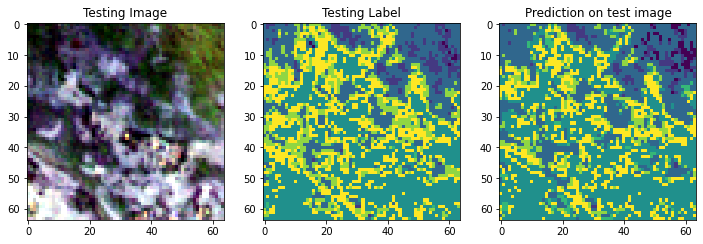

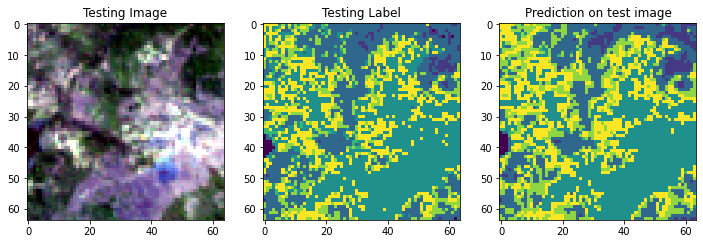

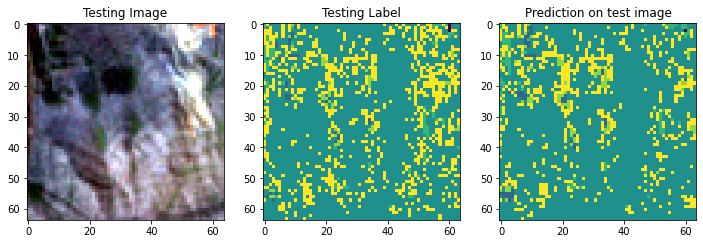

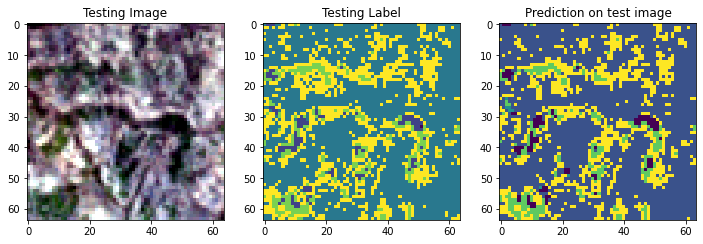

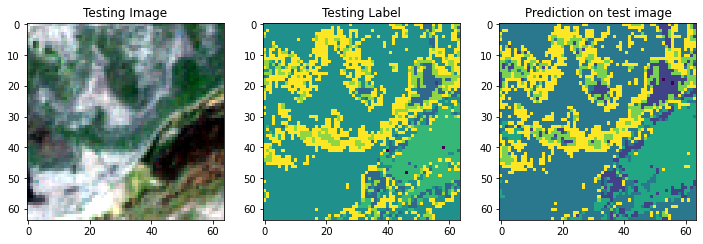

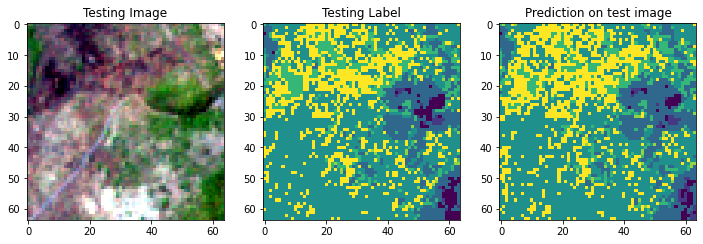

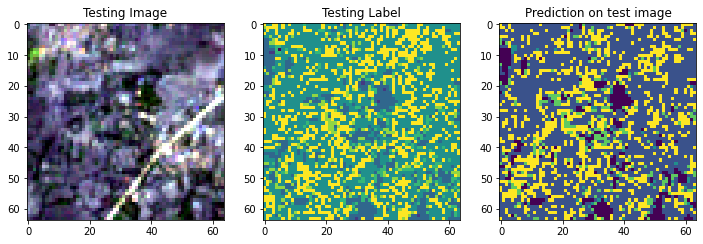

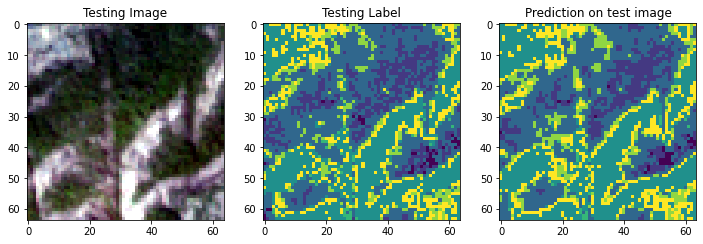

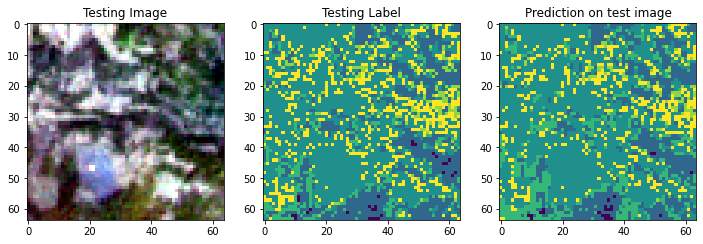

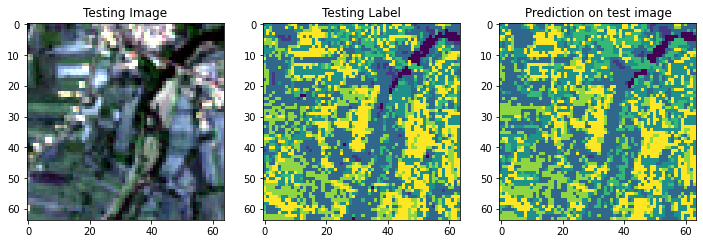

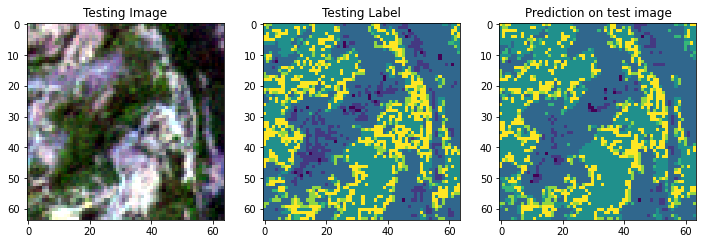

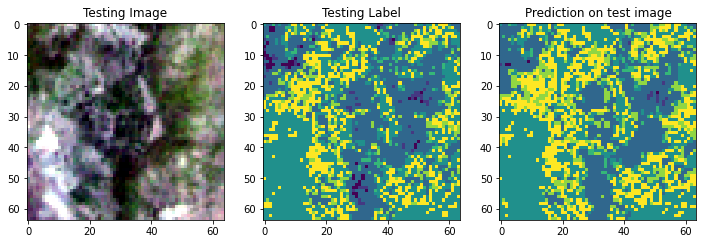

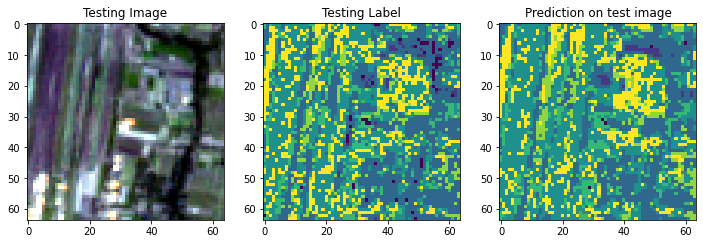

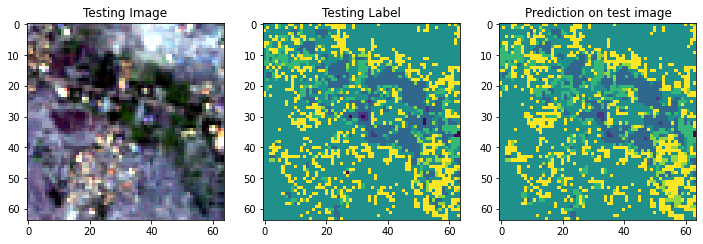

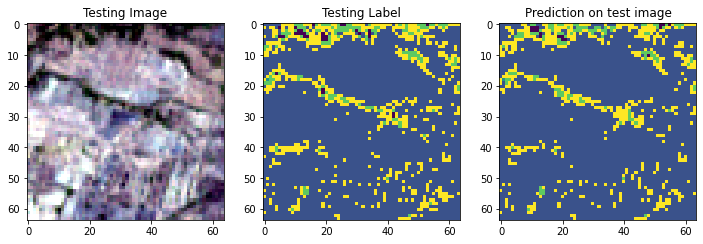

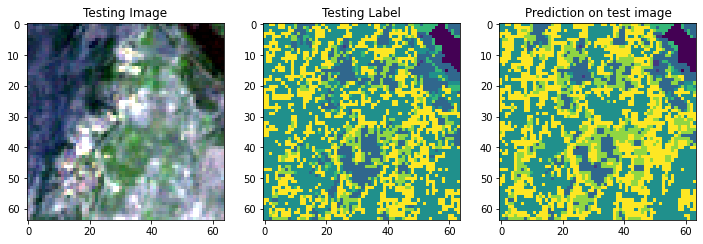

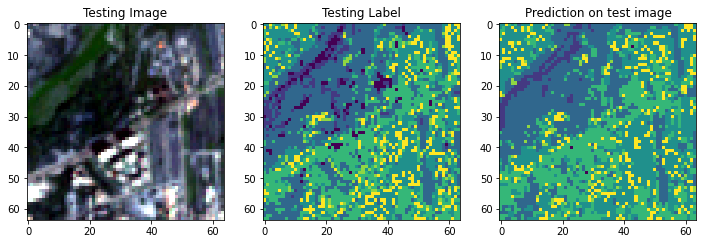

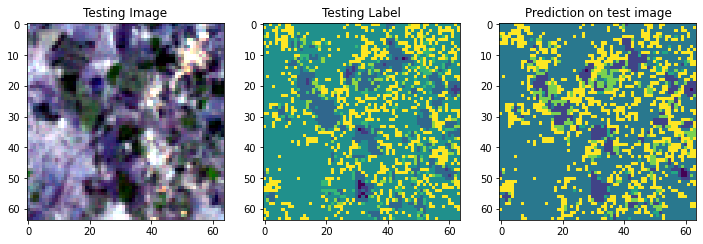

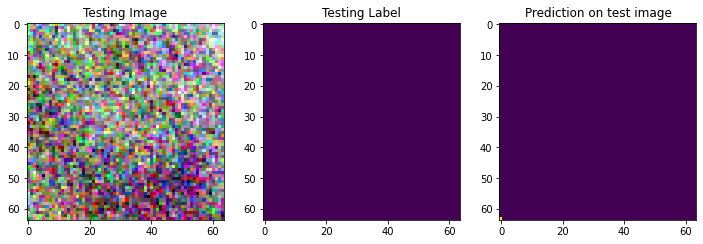

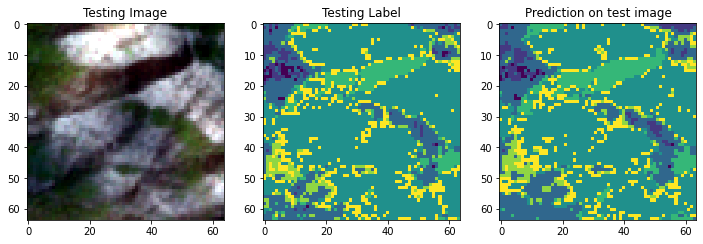

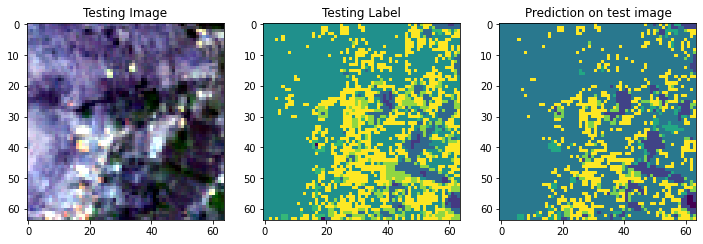

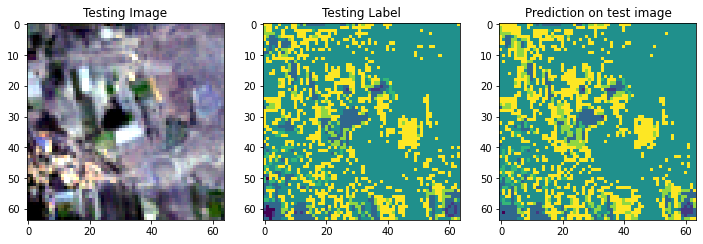

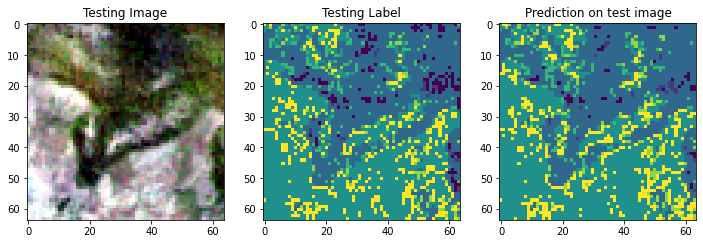

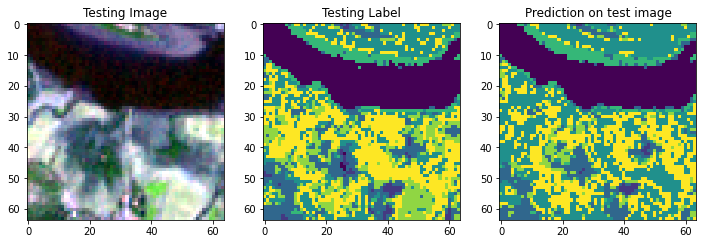

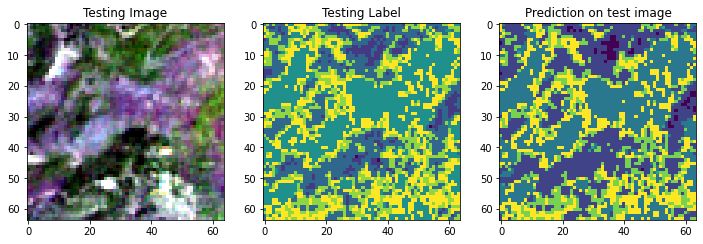

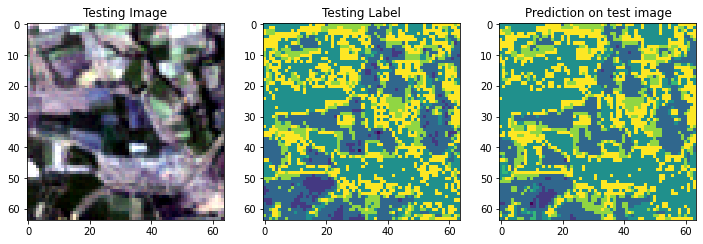

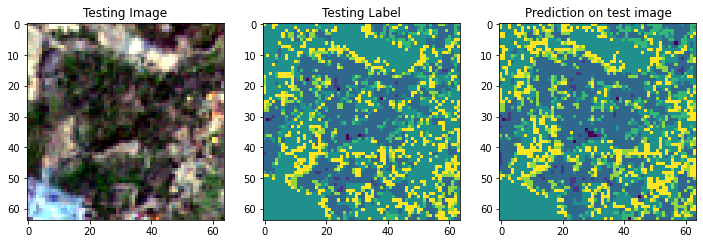

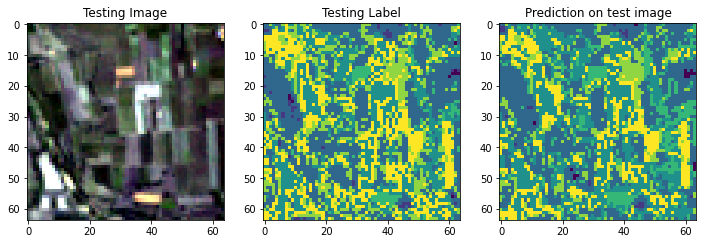

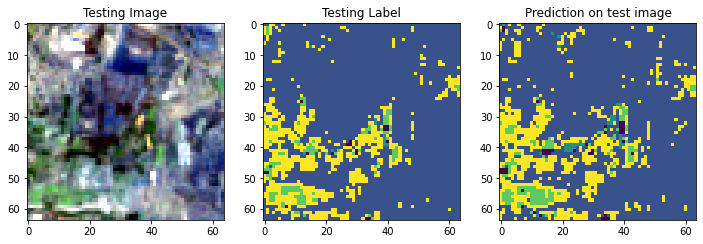

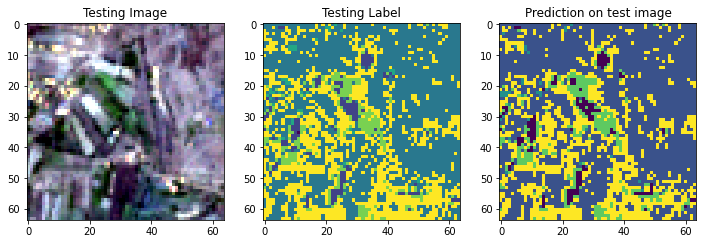

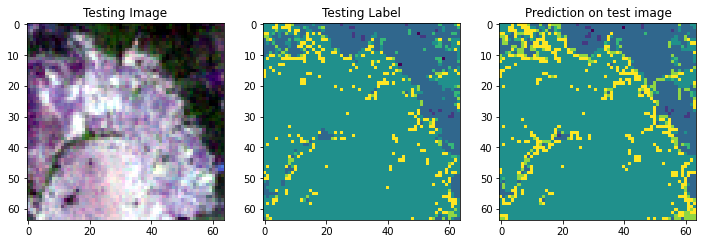

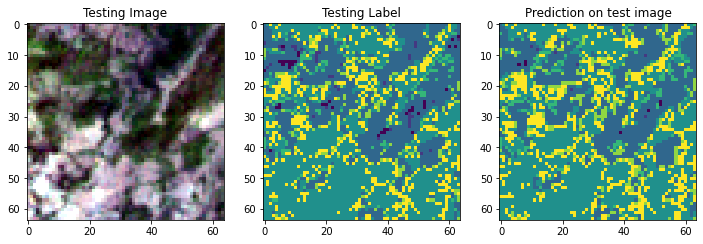

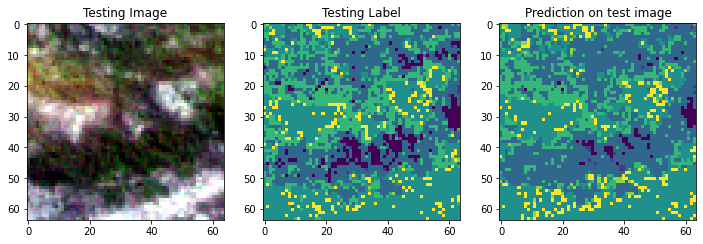

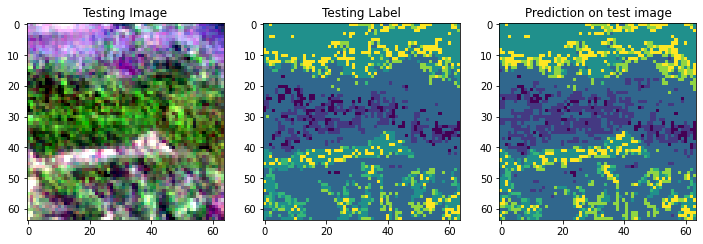

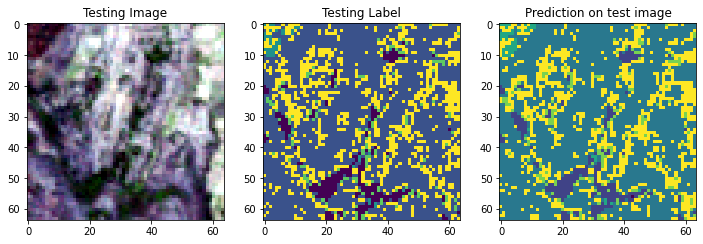

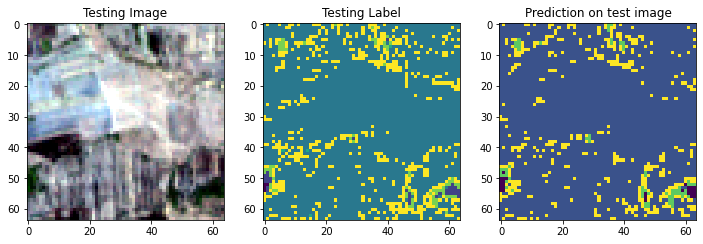

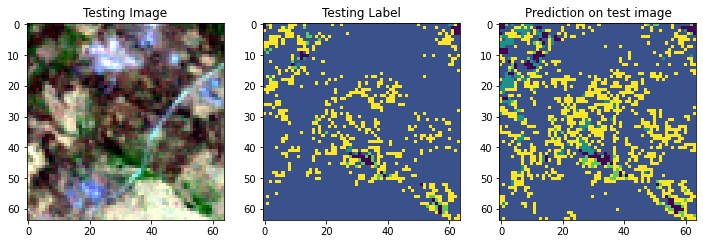

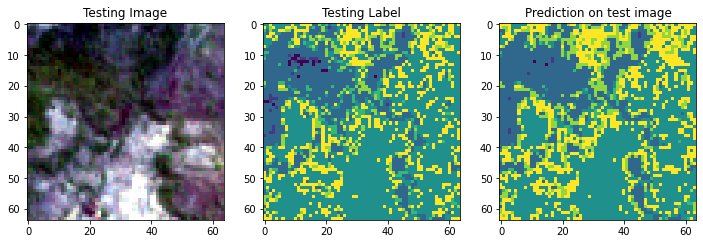

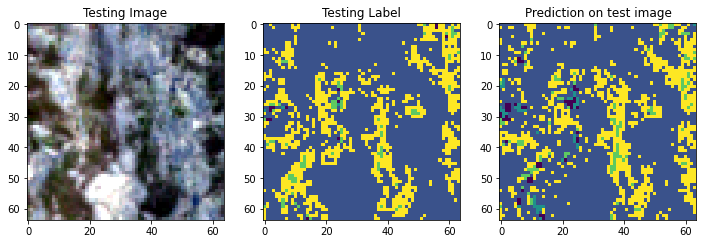

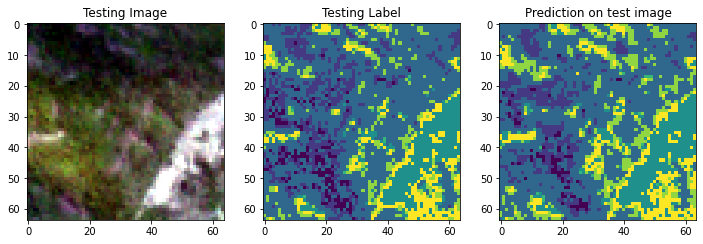

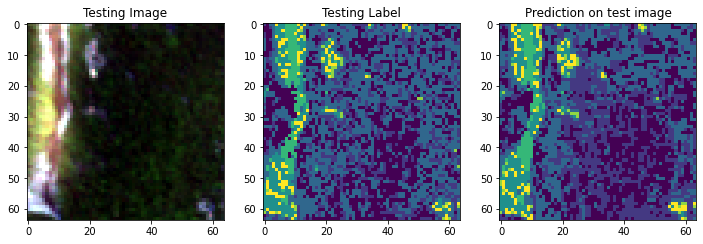

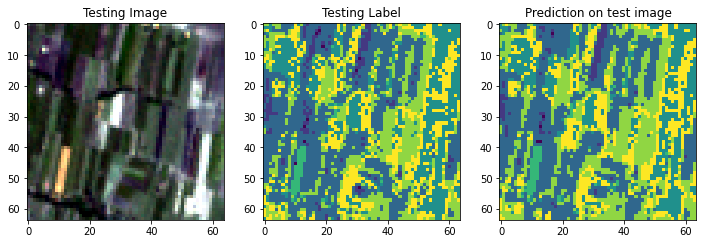

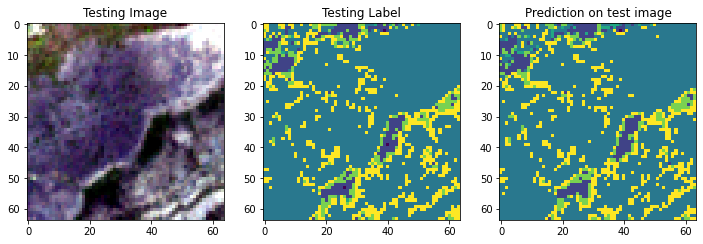

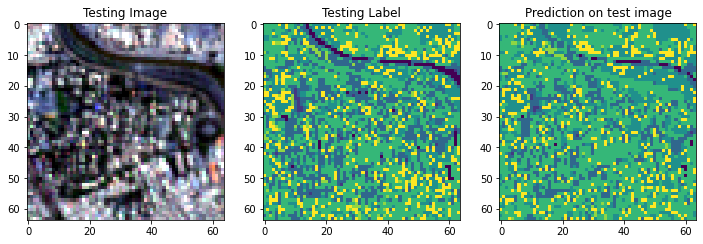

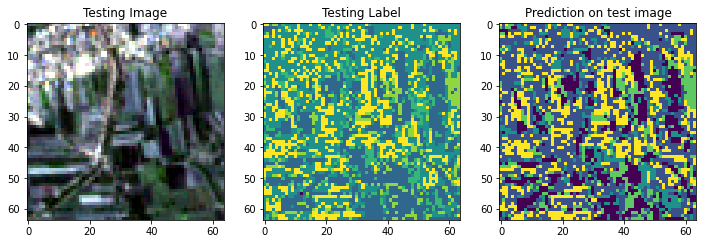

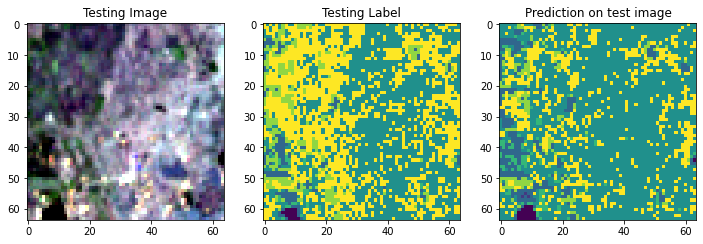

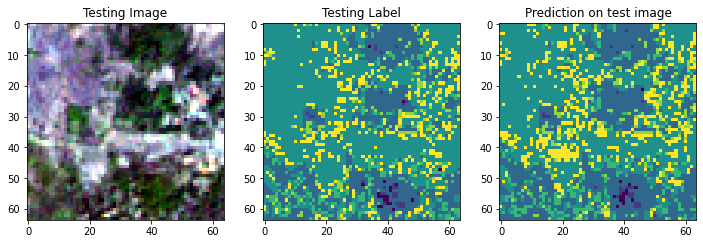

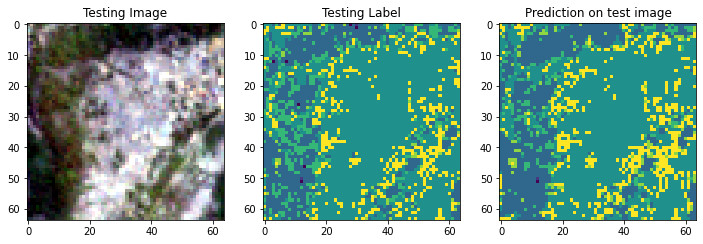

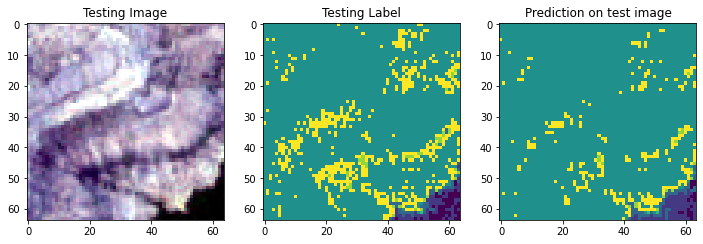

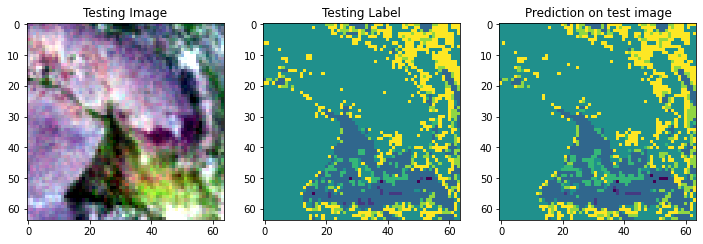

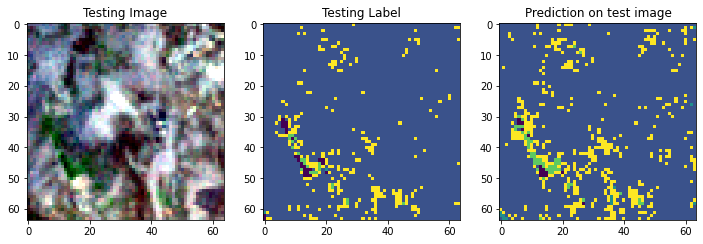

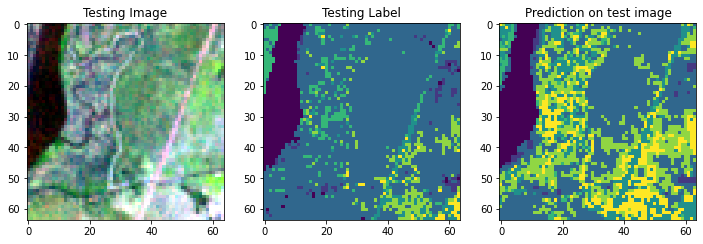

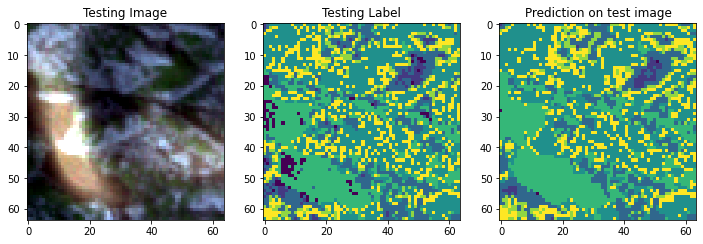

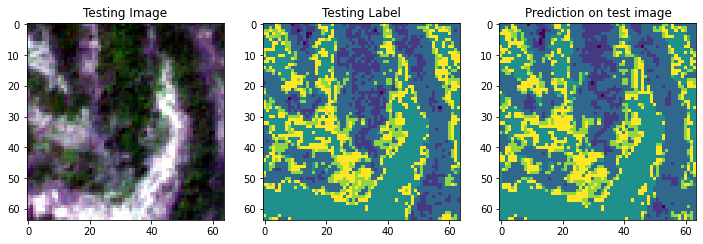

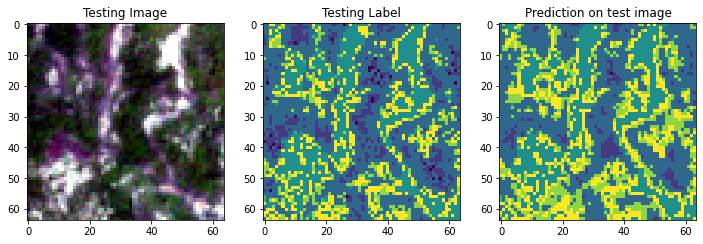

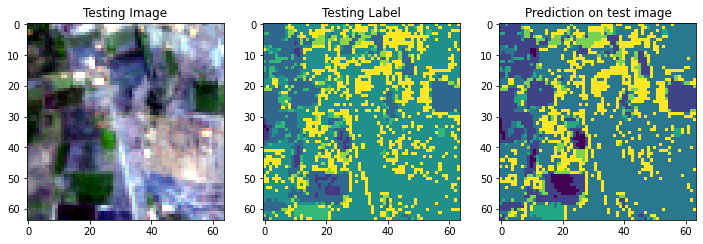

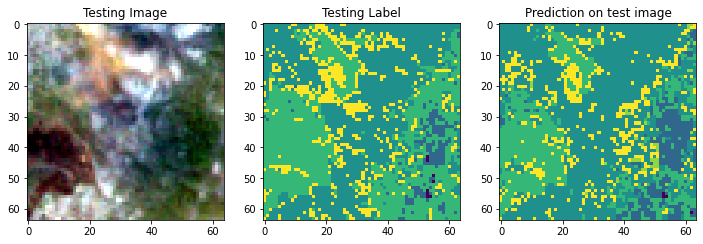

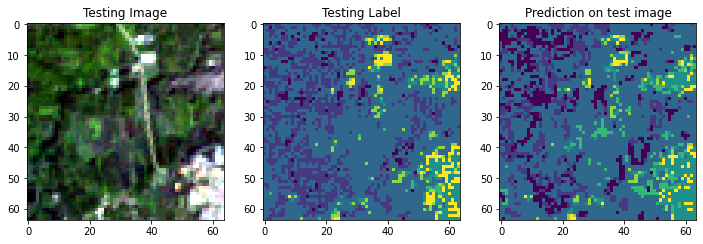

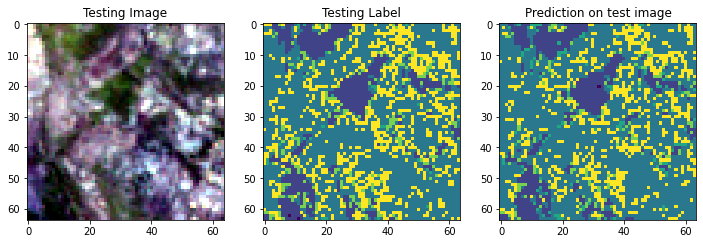

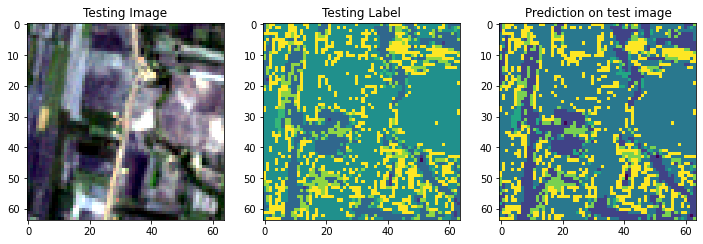

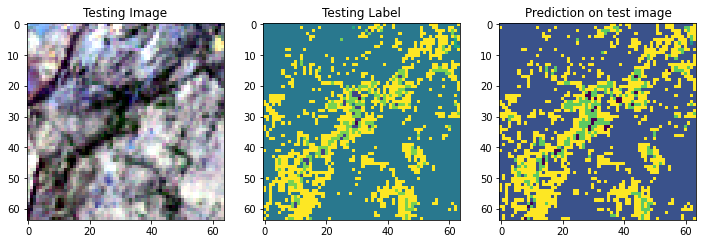

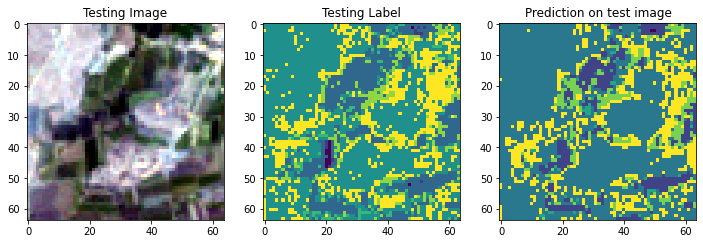

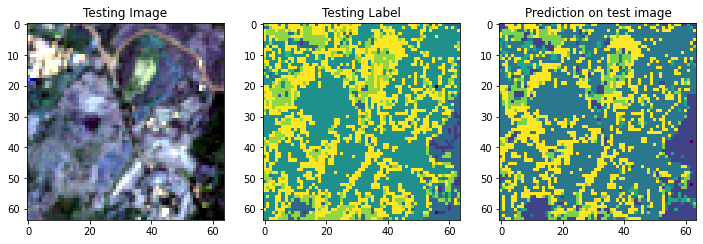

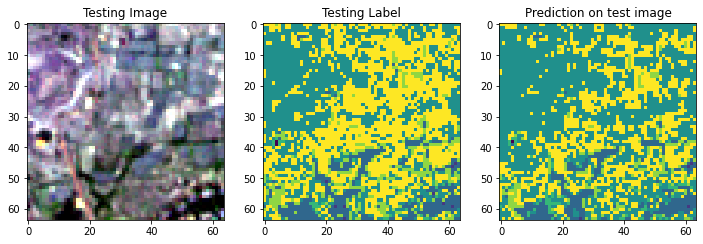

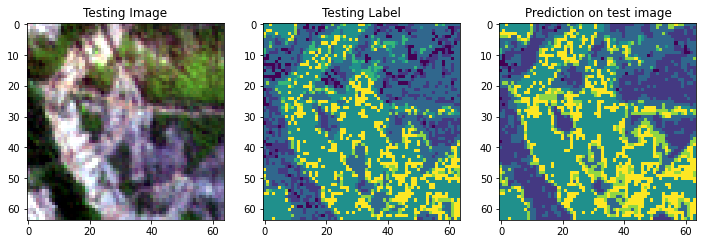

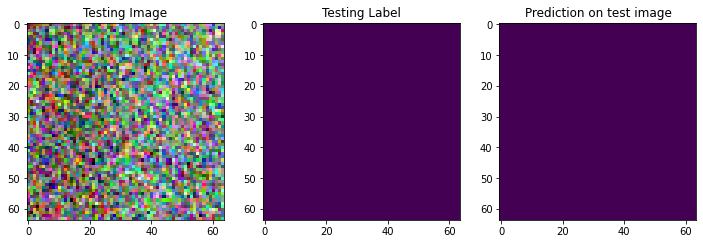

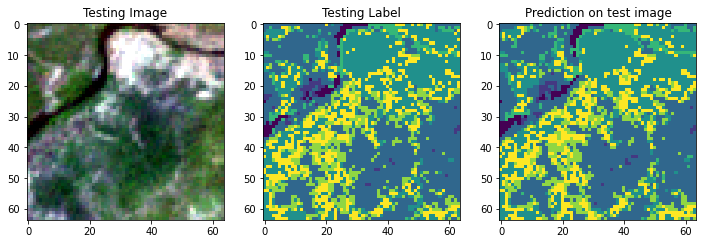

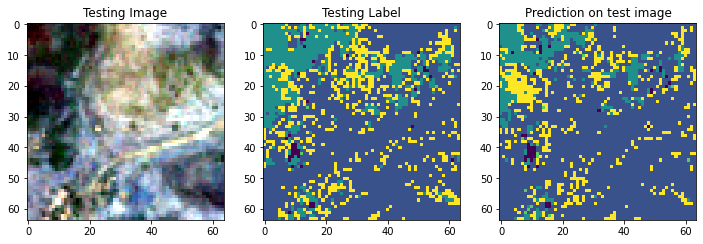

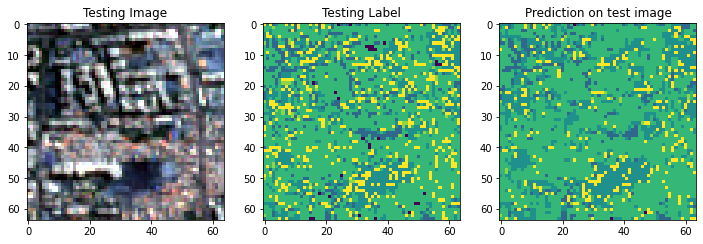

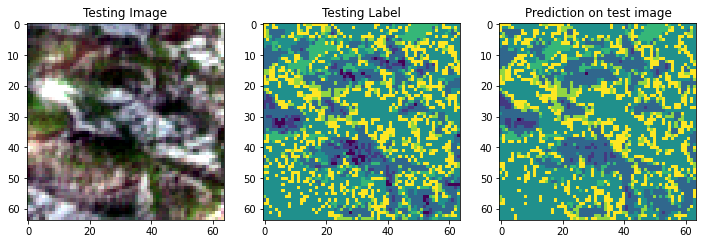

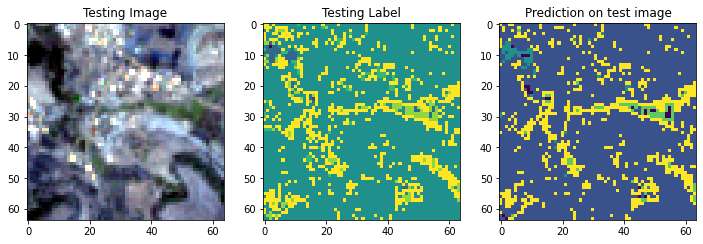

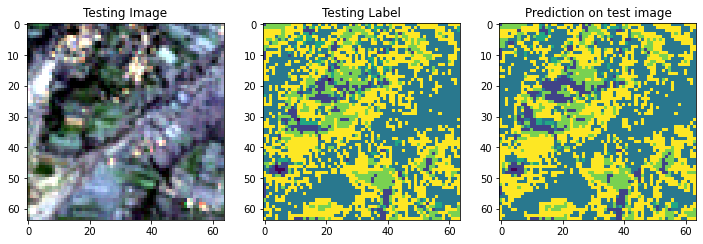

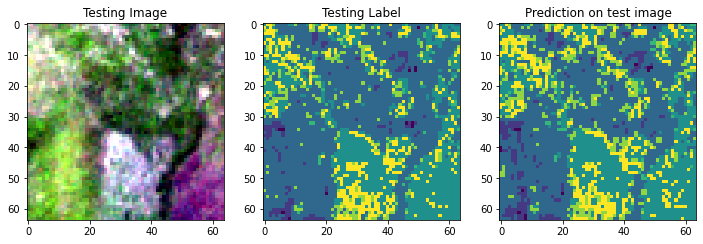

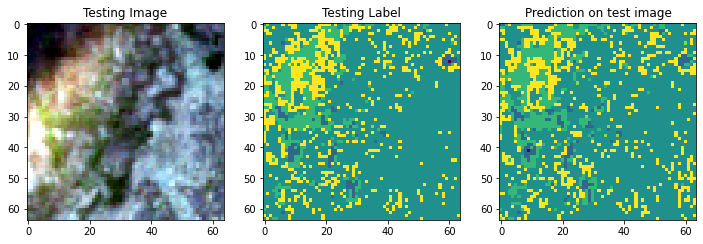

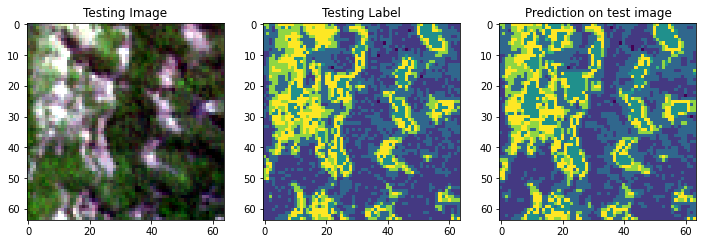

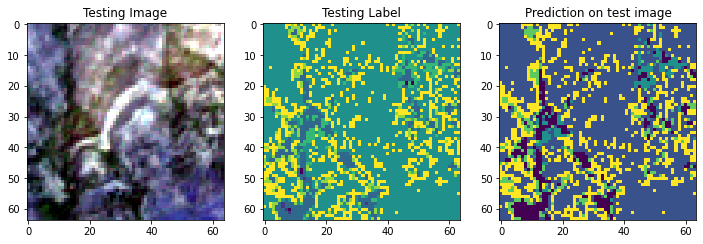

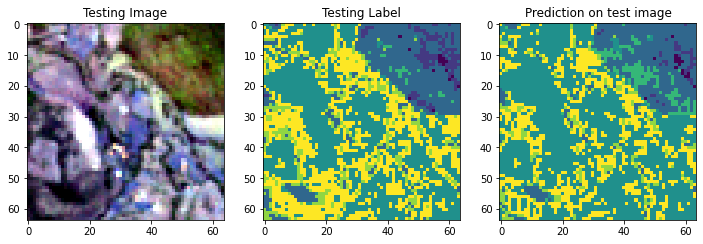

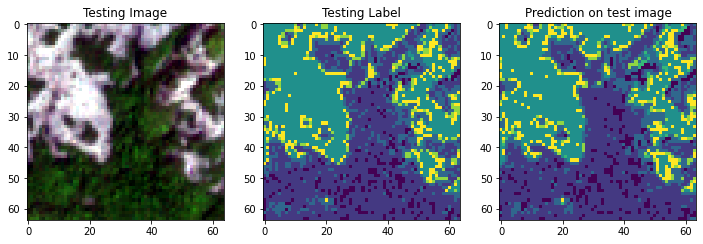

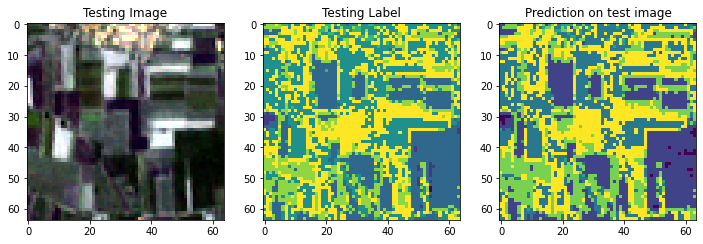

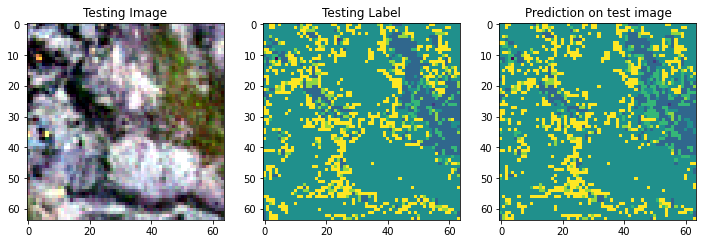

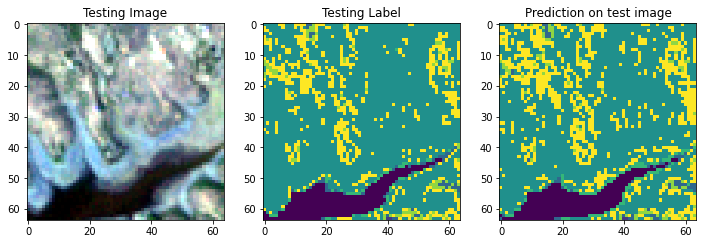

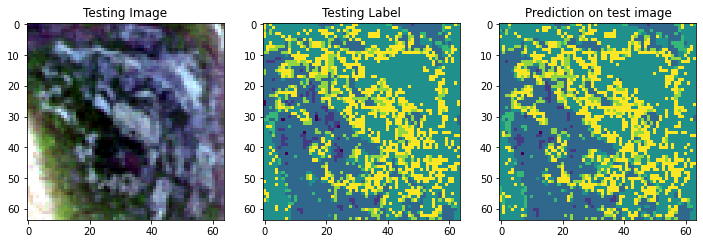

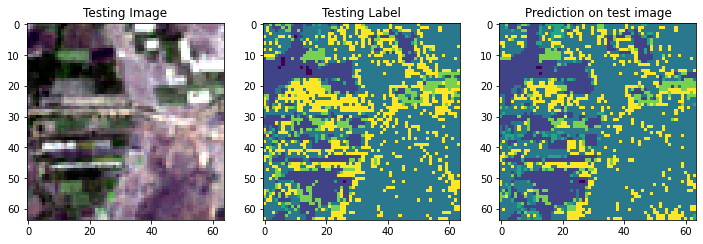

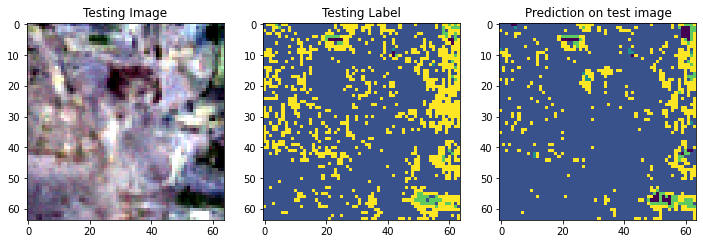

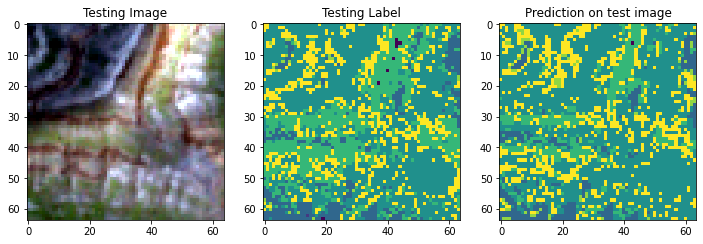

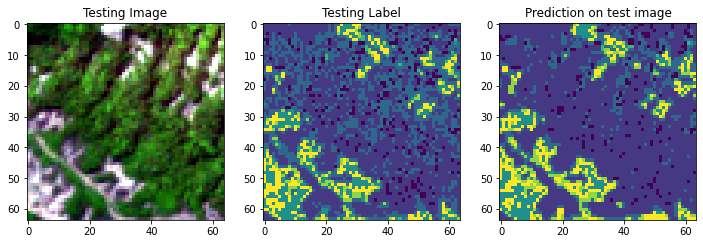

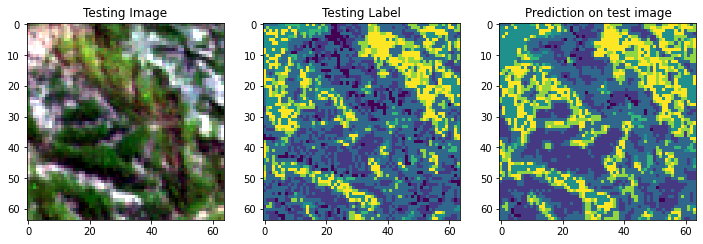

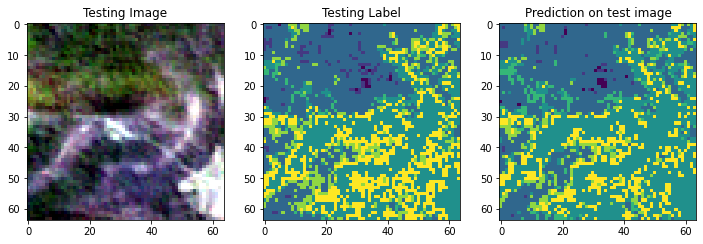

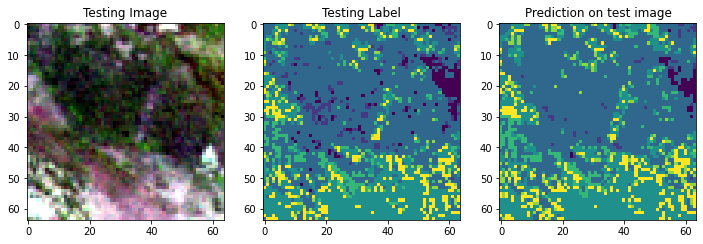

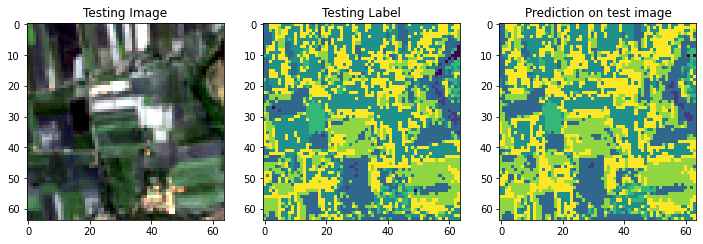

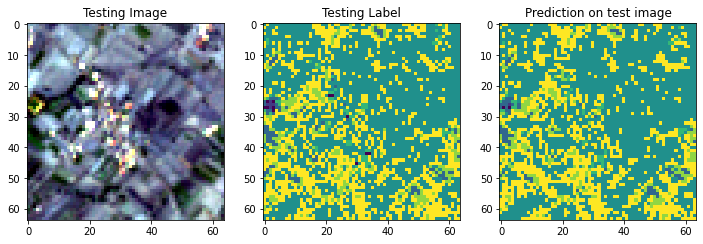

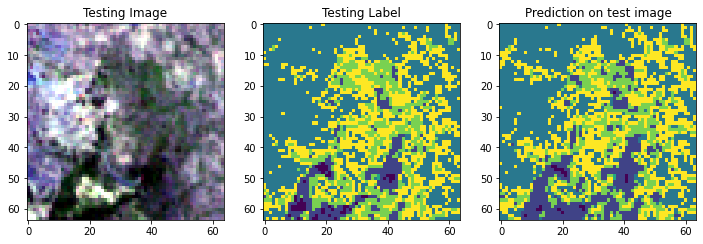

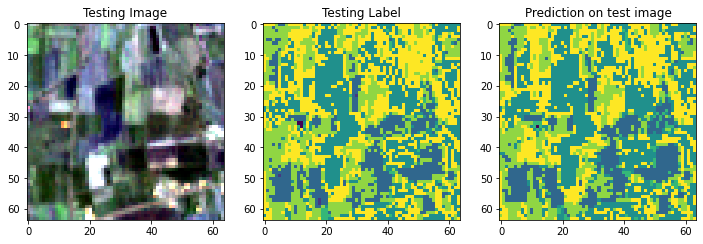

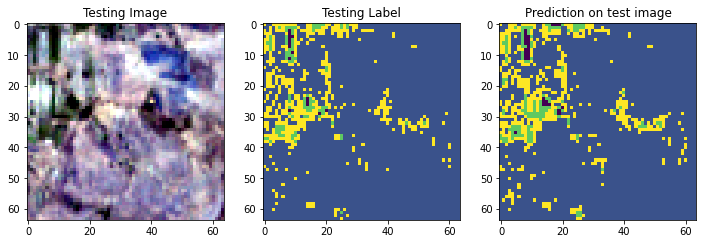

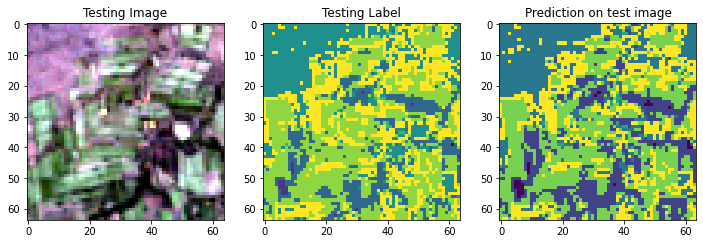

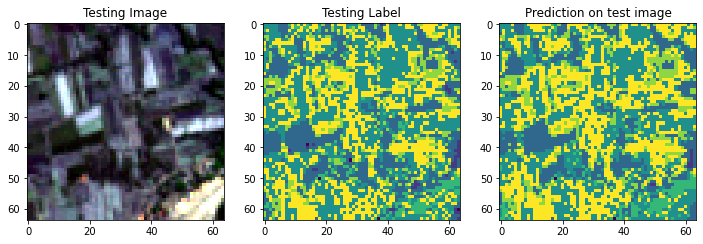

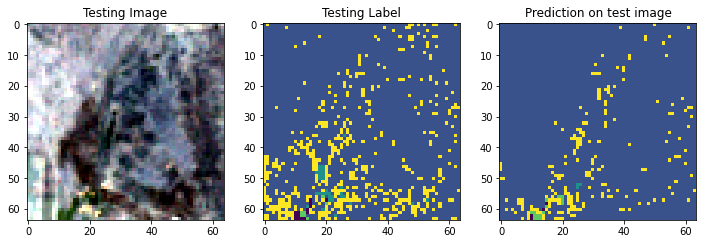

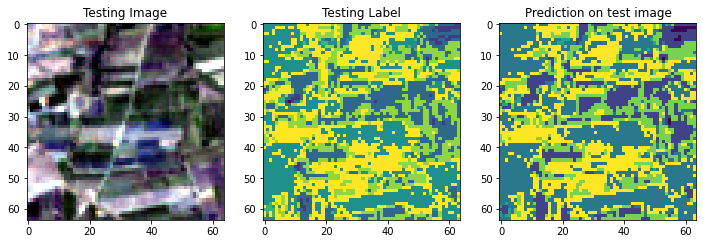

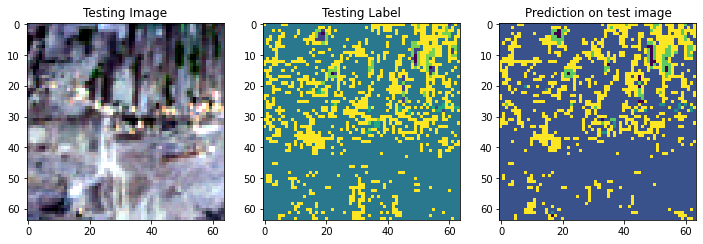

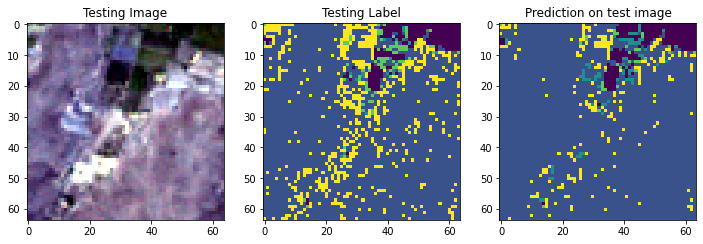

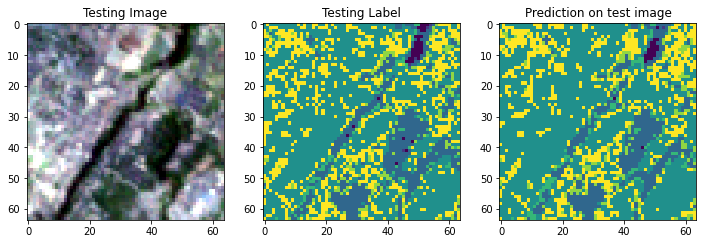

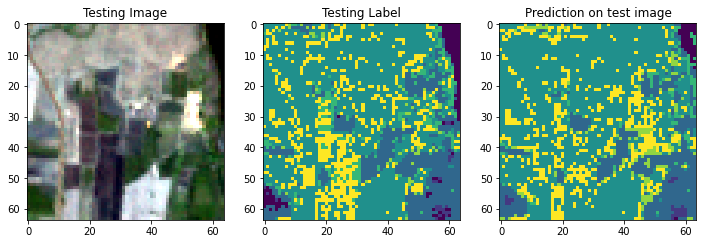

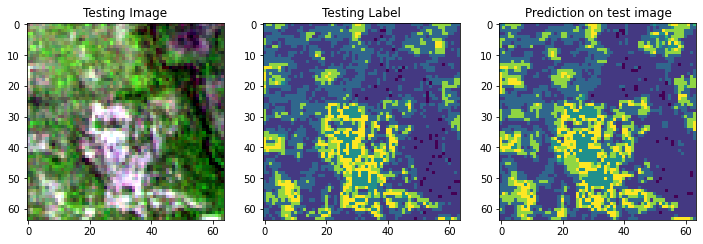

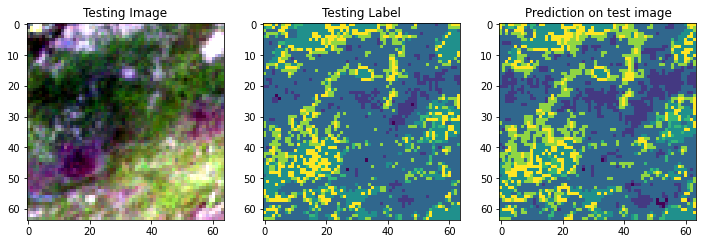

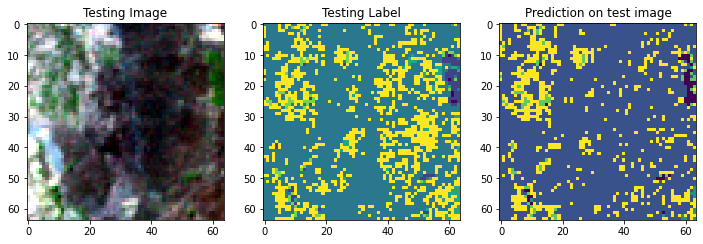

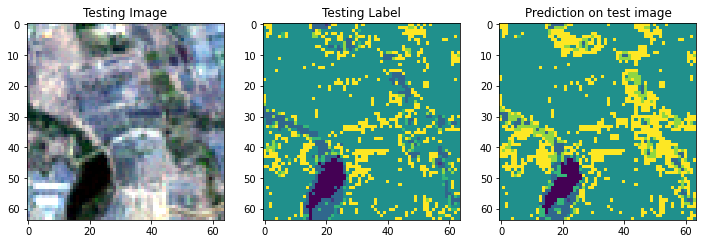

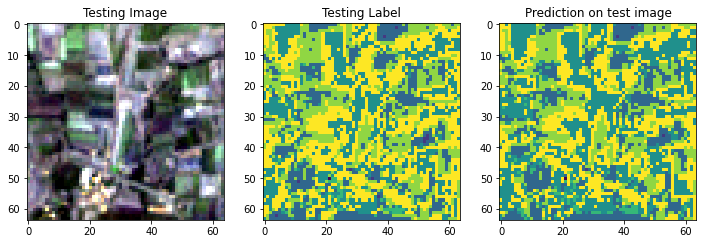

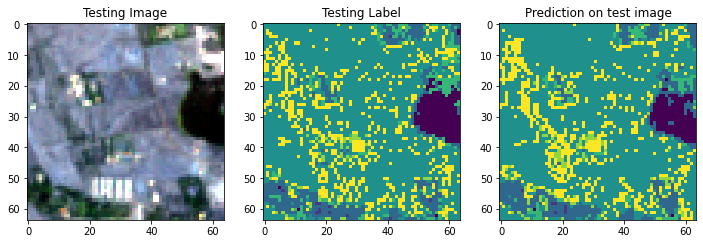

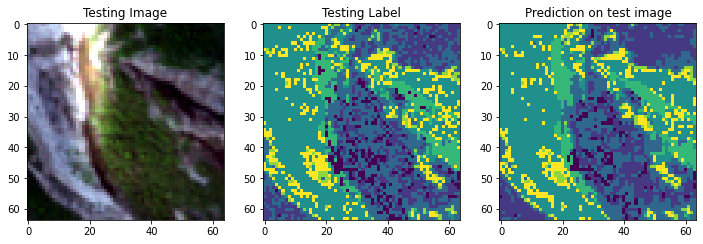

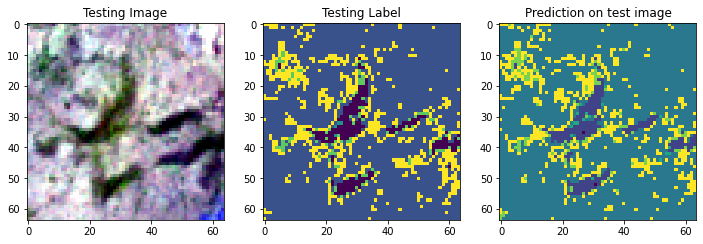

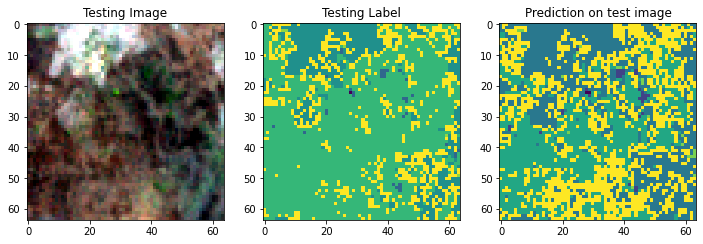

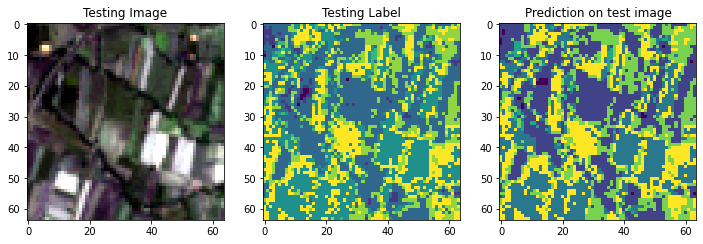

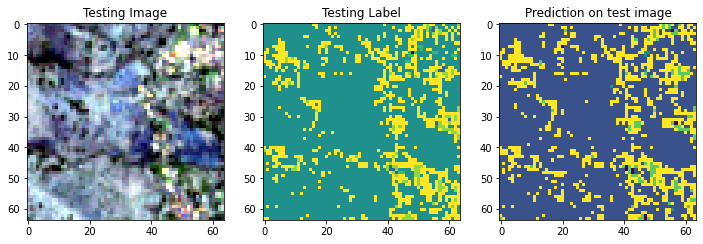

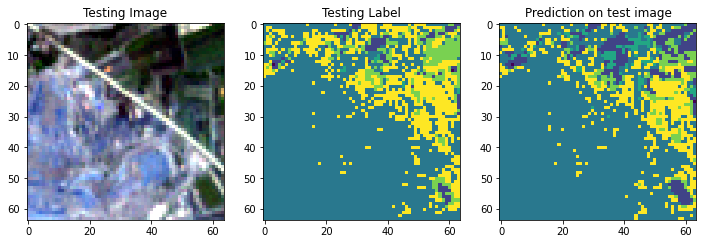

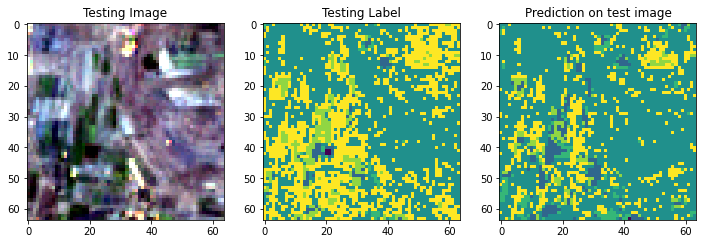

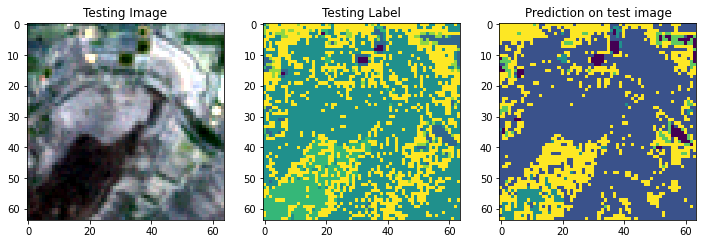

In [230]:
for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    store_path = f'/home/shrayank_mistry/Modules/current_models/model_stats/{md}_{bk}/'
    os.mkdir(store_path + 'test_output/')

    test_image_batch, test_mask_batch = test_img_gen.__next__()

    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

    for i in range(batch_size):

        path = store_path + 'test_output/'
        # os.mkdir(path)
        plt.figure(figsize = (12, 8))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(test_image_batch[i])
        # plt.savefig(f'{path}/image.jpg')

        plt.subplot(232)
        plt.title('Testing Label')
        plt.imshow(test_mask_batch_argmax[i])
        # plt.savefig(f'{path}/mask.jpg')

        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(test_pred_batch_argmax[i])
        plt.savefig(f'{path}/output_{i + 1}.jpg')

In [231]:
test_image_batch, test_mask_batch = test_img_gen.__next__()
model_data = []

for mt in models:
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
    test_pred_batch = mt.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

    cs = 8
    confusion_matrix = np.zeros((cs, cs), dtype = 'int')

    for x in range(batch_size):
        target = test_mask_batch_argmax[x]
        prediction = test_pred_batch_argmax[x]   

        r = target.shape[0]
        c = target.shape[1]

        for i in range(r):
            for j in range(c):
                target_pixel = target[i][j]
                predict_pixel = prediction[i][j]
        
                confusion_matrix[predict_pixel][target_pixel] += 1

    metrics = {}
    for c in range(1, len(classes)):
        tp, fn, fp, tn = 0, 0, 0, 0

        p, r, o, f, m = 0, 0, 0, 0, 0

        # True Positive
        tp = confusion_matrix[c][c]
        
        # False Negative
        for i in range(len(classes)):
            if i == c: continue
            fn += confusion_matrix[c][i]
        
        # False Positive
        for i in range(len(classes)):
            if i == c: continue
            fp += confusion_matrix[i][c]
        
        # True Negative
        for i in range(len(classes)):
            if i == c: continue
            for j in range(len(classes)):
                if j == c: continue

                tn += confusion_matrix[i][j]
        
        # print(f'Class {c}, Metrics = [TP {tp}, FN {fn}, FP {fp}, TN {tn}]')

        p = tp / (tp + fp)
        r = tp / (tp + fn)
        o = (tp + tn) / (tp + fp + tn + fn)
        f = (2 * tp) / ((2 * tp) + (fp + fn))
        m = ((tp * tn) - (fp * fn)) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

        metrics[classes[c]] = [p, r, o, f, m]
    
    model_data.append(metrics)


In [232]:
classes = ['Unclassified', 'Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']
headers = ['Precision', 'Recall', 'Overall-Accuracy', 'F1-Score', 'MCC']


cmp_dict_water = {}   # Water Class
cmp_dict_dforest = {} # DenseForest
cmp_dict_sforest = {} # SparseForest
cmp_dict_barren = {}  # BarrenLand
cmp_dict_urban = {}   # UrbanLand
cmp_dict_farms = {}   # FarmLand
cmp_dict_fallow = {}  # FallowLand
 
index = 0
for mn in model_names:
    cmp_dict_water[mn] = model_data[index]['Water']
    cmp_dict_dforest[mn] = model_data[index]['DenseForests']
    cmp_dict_sforest[mn] = model_data[index]['SparseForests']
    cmp_dict_barren[mn] = model_data[index]['BarrenLand']
    cmp_dict_urban[mn] = model_data[index]['UrbanLand']
    cmp_dict_farms[mn] = model_data[index]['FarmLand']
    cmp_dict_fallow[mn] = model_data[index]['FallowLand']

    index = index + 1


index = 0

In [233]:
pd.set_option("display.precision", 4)
water_df = pd.DataFrame(cmp_dict_water, index = headers)

In [234]:
print("Water Class")
water_df

Water Class


Unet-resnet50  Unet-resnet101  Unet-resnet152  \
Precision                0.6026          0.7770          0.9370   
Recall                   0.8124          0.9544          0.9417   
Overall-Accuracy         0.9230          0.9627          0.9827   
F1-Score                 0.6920          0.8566          0.9394   
MCC                      0.6585          0.8413          0.9293   

                  Unet-densenet121  Unet-densenet169  Unet-vgg19  FPN-vgg16  \
Precision                   0.9343            0.9186      0.9211     0.9336   
Recall                      0.9660            0.6875      0.9857     0.9431   
Overall-Accuracy            0.9859            0.9284      0.9868     0.9824   
F1-Score                    0.9499            0.7864      0.9523     0.9383   
MCC                         0.9418            0.7558      0.9453     0.9281   

                  Linknet-mobilenetv2  
Precision                      0.9553  
Recall                         0.7801  
Overall-Accuracy               0.9550  
F1-Score                       0.8589  
MCC                            0.8384

In [235]:
dforest_df = pd.DataFrame(cmp_dict_dforest, index = headers)
print("DenseForest Class")
dforest_df

DenseForest Class


Unet-resnet50  Unet-resnet101  Unet-resnet152  \
Precision                0.6531          0.6209          0.6375   
Recall                   0.5373          0.5741          0.5299   
Overall-Accuracy         0.9741          0.9761          0.9736   
F1-Score                 0.5895          0.5966          0.5787   
MCC                      0.5792          0.5848          0.5678   

                  Unet-densenet121  Unet-densenet169  Unet-vgg19  FPN-vgg16  \
Precision                   0.7550            0.7716      0.6343     0.7582   
Recall                      0.6186            0.6562      0.6550     0.5342   
Overall-Accuracy            0.9798            0.9820      0.9801     0.9743   
F1-Score                    0.6800            0.7092      0.6445     0.6268   
MCC                         0.6732            0.7024      0.6344     0.6240   

                  Linknet-mobilenetv2  
Precision                      0.5035  
Recall                         0.5027  
Overall-Accuracy               0.9717  
F1-Score                       0.5031  
MCC                            0.4885

In [236]:
sforest_df = pd.DataFrame(cmp_dict_sforest, index = headers)
print("SparseForest Class")
sforest_df

SparseForest Class


Unet-resnet50  Unet-resnet101  Unet-resnet152  \
Precision                0.7762          0.8295          0.7676   
Recall                   0.8971          0.8679          0.8646   
Overall-Accuracy         0.9407          0.9438          0.9332   
F1-Score                 0.8323          0.8483          0.8133   
MCC                      0.7996          0.8141          0.7748   

                  Unet-densenet121  Unet-densenet169  Unet-vgg19  FPN-vgg16  \
Precision                   0.8007            0.7570      0.8015     0.8084   
Recall                      0.9007            0.8863      0.8714     0.8651   
Overall-Accuracy            0.9455            0.9355      0.9399     0.9398   
F1-Score                    0.8478            0.8165      0.8350     0.8358   
MCC                         0.8168            0.7813      0.7994     0.7997   

                  Linknet-mobilenetv2  
Precision                      0.7264  
Recall                         0.7761  
Overall-Accuracy               0.9084  
F1-Score                       0.7505  
MCC                            0.6950

In [237]:
barren_df = pd.DataFrame(cmp_dict_barren, index = headers)
print('BarrenLand Class')
barren_df

BarrenLand Class


Unet-resnet50  Unet-resnet101  Unet-resnet152  \
Precision                0.8765          0.8740          0.8232   
Recall                   0.8084          0.8848          0.9013   
Overall-Accuracy         0.8612          0.8995          0.8881   
F1-Score                 0.8411          0.8794          0.8605   
MCC                      0.7201          0.7933          0.7696   

                  Unet-densenet121  Unet-densenet169  Unet-vgg19  FPN-vgg16  \
Precision                   0.8796            0.7807      0.9104     0.8606   
Recall                      0.8806            0.8272      0.8377     0.8563   
Overall-Accuracy            0.8995            0.8398      0.8885     0.8811   
F1-Score                    0.8801            0.8033      0.8725     0.8585   
MCC                         0.7936            0.6691      0.7759     0.7559   

                  Linknet-mobilenetv2  
Precision                      0.8693  
Recall                         0.8043  
Overall-Accuracy               0.8566  
F1-Score                       0.8355  
MCC                            0.7104

In [238]:
urban_df = pd.DataFrame(cmp_dict_urban, index = headers)
print('UrbanLand Class')
urban_df

UrbanLand Class


Unet-resnet50  Unet-resnet101  Unet-resnet152  \
Precision                0.5777          0.5097          0.5508   
Recall                   0.7481          0.4969          0.6926   
Overall-Accuracy         0.9723          0.9548          0.9689   
F1-Score                 0.6520          0.5032          0.6136   
MCC                      0.6436          0.4796          0.6019   

                  Unet-densenet121  Unet-densenet169  Unet-vgg19  FPN-vgg16  \
Precision                   0.5138            0.3438      0.4682     0.3414   
Recall                      0.8080            0.8390      0.6902     0.6725   
Overall-Accuracy            0.9727            0.9676      0.9667     0.9630   
F1-Score                    0.6281            0.4877      0.5579     0.4529   
MCC                         0.6317            0.5250      0.5523     0.4628   

                  Linknet-mobilenetv2  
Precision                      0.2897  
Recall                         0.2725  
Overall-Accuracy               0.9334  
F1-Score                       0.2808  
MCC                            0.2461

In [239]:
farms_df = pd.DataFrame(cmp_dict_farms, index = headers)
print('FarmLand Class')
farms_df

FarmLand Class


Unet-resnet50  Unet-resnet101  Unet-resnet152  \
Precision                0.7251          0.8152          0.7867   
Recall                   0.5810          0.6012          0.5150   
Overall-Accuracy         0.9662          0.9693          0.9596   
F1-Score                 0.6451          0.6920          0.6225   
MCC                      0.6318          0.6850          0.6172   

                  Unet-densenet121  Unet-densenet169  Unet-vgg19  FPN-vgg16  \
Precision                   0.8037            0.7612      0.6639     0.7486   
Recall                      0.5973            0.4939      0.6137     0.5471   
Overall-Accuracy            0.9687            0.9568      0.9681     0.9631   
F1-Score                    0.6853            0.5991      0.6378     0.6322   
MCC                         0.6774            0.5925      0.6217     0.6216   

                  Linknet-mobilenetv2  
Precision                      0.3231  
Recall                         0.4704  
Overall-Accuracy               0.9559  
F1-Score                       0.3831  
MCC                            0.3679

In [240]:
fallow_df = pd.DataFrame(cmp_dict_fallow, index = headers)
print('FallowLand Class')
fallow_df

FallowLand Class


Unet-resnet50  Unet-resnet101  Unet-resnet152  \
Precision                0.6958          0.7501          0.7533   
Recall                   0.6011          0.6447          0.5805   
Overall-Accuracy         0.8988          0.9123          0.8954   
F1-Score                 0.6450          0.6934          0.6557   
MCC                      0.5885          0.6451          0.6023   

                  Unet-densenet121  Unet-densenet169  Unet-vgg19  FPN-vgg16  \
Precision                   0.7320            0.6000      0.6256     0.6142   
Recall                      0.6289            0.5931      0.6253     0.5862   
Overall-Accuracy            0.9075            0.8927      0.9010     0.8917   
F1-Score                    0.6765            0.5965      0.6255     0.5999   
MCC                         0.6253            0.5347      0.5684     0.5375   

                  Linknet-mobilenetv2  
Precision                      0.3715  
Recall                         0.5542  
Overall-Accuracy               0.8774  
F1-Score                       0.4448  
MCC                            0.3885

### Training Loss Model Comparison

In [241]:
# model_names = ['Unet-resnet50', 'Unet-resnet101', 'Unet-resnet152']

model_names = ['Unet-resnet50', 'Unet-resnet101', 'Unet-resnet152', 'Unet-densenet121', 'Unet-densenet169',
               'Unet-vgg19', 'FPN-vgg16', 'Linknet-mobilenetv2']
# model_names = ['Unet-resnet50']
models_path = '/home/shrayank_mistry/Modules/current_models/model_stats/'

mds_histories = []

for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    file = open(f'{models_path}/{md}_{bk}/histroy_dict.txt', 'r')
    contents = file.read()

    dt = ast.literal_eval(contents)
    mds_histories.append(dt['train_loss'])


In [242]:
mds_hist_df = pd.DataFrame((mds_histories), index = model_names)
mds_hist_df = mds_hist_df.T

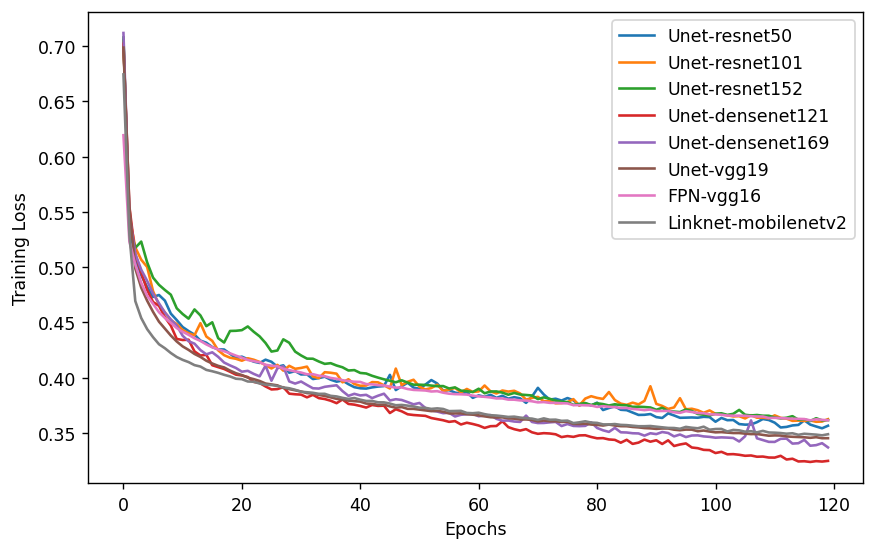

In [243]:
plt.figure(figsize = (8, 5), dpi = 125)
sns.lineplot(data = mds_hist_df, dashes = False);

plt.xlabel('Epochs');
plt.ylabel('Training Loss');

### Training IoU Comparison

In [244]:
mds_histories = []

for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    file = open(f'{models_path}/{md}_{bk}/histroy_dict.txt', 'r')
    contents = file.read()

    dt = ast.literal_eval(contents)
    mds_histories.append(dt['iou'])

In [245]:
mds_hist_df = pd.DataFrame((mds_histories), index = model_names)
mds_hist_df = mds_hist_df.T

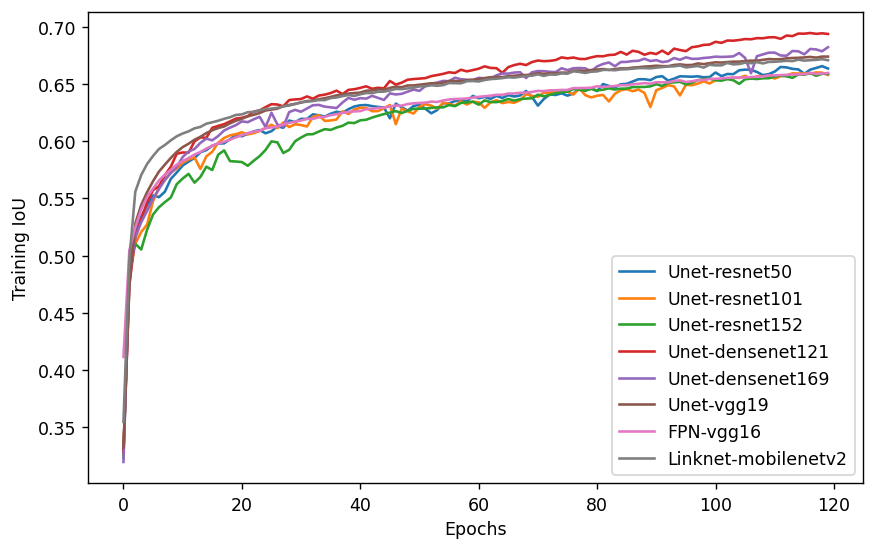

In [246]:
plt.figure(figsize = (8, 5), dpi = 125)
sns.lineplot(data = mds_hist_df, dashes = False);

plt.xlabel('Epochs');
plt.ylabel('Training IoU');